# **PROJET ITK-VTK**

## Auteurs
### Majeure IMAGE

- David CHEMALY
    - login: david.chemaly
<br /> <br />
- Thuraya SHANBARI
    - login: thuraya.shanbari

# Import des librairies

In [1]:
import itk
itk.Version.GetITKVersion()

'5.3.0'

In [2]:
import vtk
vtk.vtkVersion.GetVTKVersion()

'9.2.6'

In [3]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.7.1'

In [4]:
import numpy as np
np.__version__

'1.24.1'

# Paramètres

Tout d'abord, nous allons définir les paramètres de notre programme. Nous allons utiliser les paramètres suivants:

In [5]:
fixed_image_path = 'Data/case6_gre1.nrrd'
moving_image_path = 'Data/case6_gre2.nrrd'

Nous avons définis la dimension de l'image, les types de pixel en entré et les types de pixel de sortie.

In [6]:
image1_path = 'Data/case6_gre1.nrrd'
image2_path = 'Data/case6_gre2.nrrd'

Dimension = 3
PixelTypeF = itk.ctype('float')
ImageTypeF = itk.Image[PixelTypeF, Dimension]

PixelTypeUC = itk.ctype('unsigned char')
ImageTypeUC = itk.Image[PixelTypeUC, Dimension]

# Chargement des données

L'implémentation de la fonction de chargement des données est la suivante:

In [7]:
def read_file(file_path, ImageType):
    readerType = itk.ImageFileReader[ImageType]
    reader = readerType.New()
    reader.SetFileName(file_path)
    reader.Update()
    image = reader.GetOutput()
    return image

Ensuite, nous allons charger les données en utilisant la fonction précédente, et nous allons afficher la taille des images chargées.

In [8]:
image1F = read_file(image1_path, ImageTypeF)
image2F = read_file(image2_path, ImageTypeF)

image1UC = read_file(image1_path, ImageTypeUC)
image2UC = read_file(image2_path, ImageTypeUC)

print("image1F size: " + str(image1F.GetLargestPossibleRegion().GetSize()))
print("image2F size: " + str(image2F.GetLargestPossibleRegion().GetSize()))

print("image1UC size: " + str(image1UC.GetLargestPossibleRegion().GetSize()))
print("image2UC size: " + str(image2UC.GetLargestPossibleRegion().GetSize()))

image1F size: itkSize3 ([256, 256, 176])
image2F size: itkSize3 ([256, 256, 176])
image1UC size: itkSize3 ([256, 256, 176])
image2UC size: itkSize3 ([256, 256, 176])


## Affichage des données

Nous allons afficher deux images côte à côte, l'image fixe et l'image mobile pour pouvoir les comparer pour le recalage. Pour cela nous allons utiliser la fonction suivante:

In [9]:
def display_images(image1, image2, slice_number):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image1[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.show()

Voici un exemple d'affichage des images:

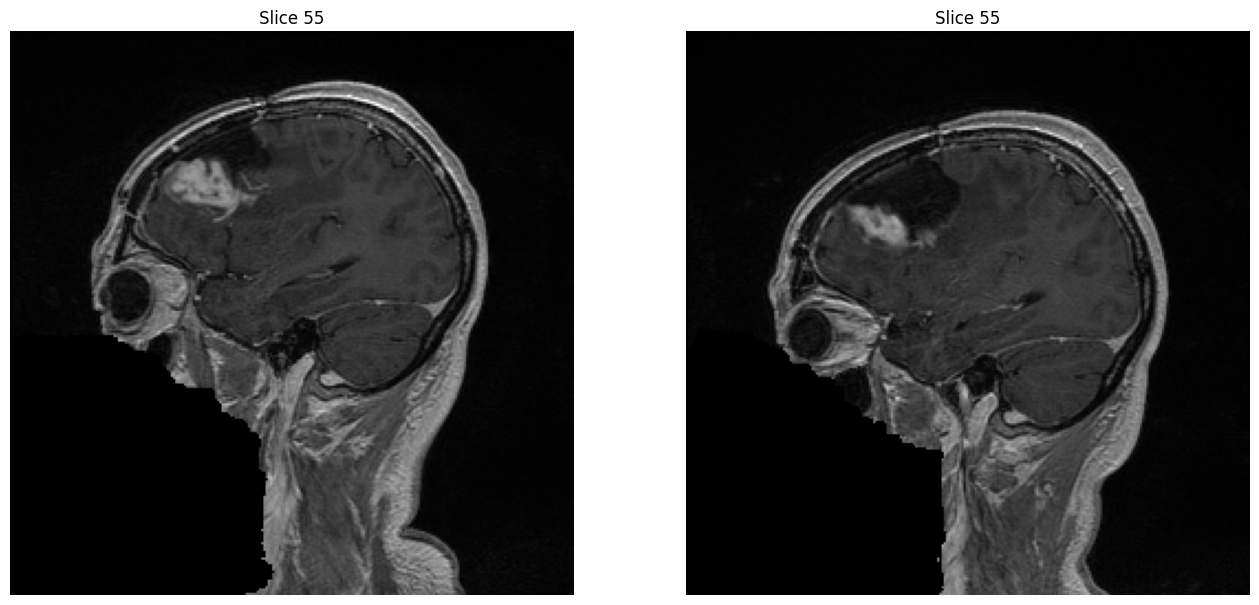

In [10]:
display_images(image1F, image2F, 55)

Nous avons aussi une fonction qui permet d'afficher une image:

In [11]:
def display_image(image, slice_number):
    plt.imshow(image[slice_number,:,:], cmap='gray')
    plt.show()

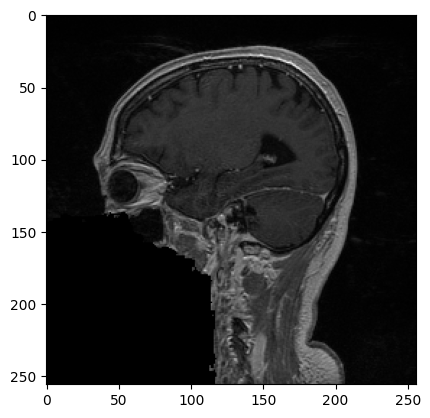

In [12]:
display_image(image1F, 116)

# Partie 1 : Recalage
---

Cette fonction resample_image prend trois paramètres en entrée : `fixed_image`, `moving_image`, et `transform`. Elle effectue une opération de rééchantillonnage sur l'image moving_image en utilisant un filtre de rééchantillonnage `itk.ResampleImageFilter`.

In [13]:
def resample_image(fixed_image, moving_image, transform):
    resampleFilterType = itk.ResampleImageFilter[ImageTypeF, ImageTypeF]
    resampleFilter = resampleFilterType.New()
    resampleFilter.SetInput(moving_image)
    resampleFilter.SetTransform(transform)
    resampleFilter.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampleFilter.SetOutputOrigin(fixed_image.GetOrigin())
    resampleFilter.SetOutputSpacing(fixed_image.GetSpacing())
    resampleFilter.SetOutputDirection(fixed_image.GetDirection())
    resampleFilter.SetDefaultPixelValue(100)
    resampleFilter.Update()
    return resampleFilter.GetOutput()

### 1. Recalage rigide

La fonction `register_images_rigid3D` effectue l'enregistrement de deux images tridimensionnelles, `fixed_image` et `moving_image`, en utilisant une transformation rigide versor en 3D. Voici comment la fonction est implémentée: 

In [14]:
def register_images_rigid3D(fixed_image, moving_image):
    
    TransformType = itk.VersorRigid3DTransform[itk.D]
    OptimizerType = itk.RegularStepGradientDescentOptimizerv4[itk.D]
    MetricType = itk.MeanSquaresImageToImageMetricv4[ImageTypeF, ImageTypeF]
    RegistrationType = itk.ImageRegistrationMethodv4[ImageTypeF, ImageTypeF]

    metric = MetricType.New()
    optimizer = OptimizerType.New()
    registration = RegistrationType.New()

    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)

    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)

    initial_transform = TransformType.New()

    TransformInitializerType = itk.CenteredTransformInitializer[TransformType, ImageTypeF, ImageTypeF]
    initializer = TransformInitializerType.New()

    initializer.SetTransform(initial_transform)
    initializer.SetFixedImage(fixed_image)
    initializer.SetMovingImage(moving_image)
    initializer.MomentsOn()
    initializer.InitializeTransform()

    VersorType = itk.Versor[itk.D]
    VectorType = itk.Vector[itk.D, Dimension]

    rotation = VersorType()

    axis = VectorType()
    axis[0] = 0.0
    axis[1] = 0.0
    axis[2] = 1.0

    angle = 0.0

    rotation.Set(axis, angle)

    initial_transform.SetRotation(rotation)

    registration.SetInitialTransform(initial_transform)

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(initial_transform.GetNumberOfParameters())

    translation_scale = 1.0 / 1000.0

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0

    optimizer_scales[3] = translation_scale
    optimizer_scales[4] = translation_scale
    optimizer_scales[5] = translation_scale

    optimizer.SetScales(optimizer_scales)
    optimizer.SetNumberOfIterations(200)
    optimizer.SetLearningRate(0.1)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetReturnBestParametersAndValue(True)

    numberOfLevels = 1
    shrinkFactorsPerLevel = [1]
    smoothingSigmasPerLevel = [0]

    registration.SetNumberOfLevels(numberOfLevels)
    registration.SetSmoothingSigmasPerLevel(smoothingSigmasPerLevel)
    registration.SetShrinkFactorsPerLevel(shrinkFactorsPerLevel)
    
    try:
        registration.Update()
        print("Optimizer stop condition: " + str(registration.GetOptimizer().GetStopConditionDescription()))
    except Exception as err:
        print(err)
        return None
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    versorX = finalParameters[0]
    versorY = finalParameters[1]
    versorZ = finalParameters[2]
    finalTranslationX = finalParameters[3]
    finalTranslationY = finalParameters[4]
    finalTranslationZ = finalParameters[5]
    numberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" versor X      = " + str(versorX))
    print(" versor Y      = " + str(versorY))
    print(" versor Z      = " + str(versorZ))
    print(" Translation X = " + str(finalTranslationX))
    print(" Translation Y = " + str(finalTranslationY))
    print(" Translation Z = " + str(finalTranslationZ))
    print(" Iterations    = " + str(numberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetFixedParameters(registration.GetOutput().Get().GetFixedParameters())
    finalTransform.SetParameters(registration.GetOutput().Get().GetParameters())

    matrix = finalTransform.GetMatrix()
    offset = finalTransform.GetOffset()

    print("Matrix = ", matrix)
    print("Offset = ", offset)

    registered_image = resample_image(fixed_image, moving_image, finalTransform)

    return registered_image

In [15]:
registered_image_rigid = register_images_rigid3D(image1F, image2F)
print("Registered image size: " + str(registered_image_rigid.GetLargestPossibleRegion().GetSize()))

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 140 iterations. Current step (0.00078125) is less than minimum step (0.001).
Result = 
 versor X      = 0.0011300177987424683
 versor Y      = -0.00776307526932031
 versor Z      = 0.024059544151672156
 Translation X = -1.1528900645049893
 Translation Y = -3.674823328503332
 Translation Z = -59.81114557237433
 Iterations    = 141
 Metric value  = 9321.632033208292
Matrix =  itkMatrixD33 ([[0.9987217459951532, -0.048121222835267395, -0.015466802812191373], [0.04808613318235815, 0.9988397227899766, -0.002632863918124241], [0.01557555366467545, 0.001885759709344376, 0.9998769154442748]])
Offset =  itkVectorD3 ([-0.0501262, -3.33717, -59.754])
Registered image size: itkSize3 ([256, 256, 176])


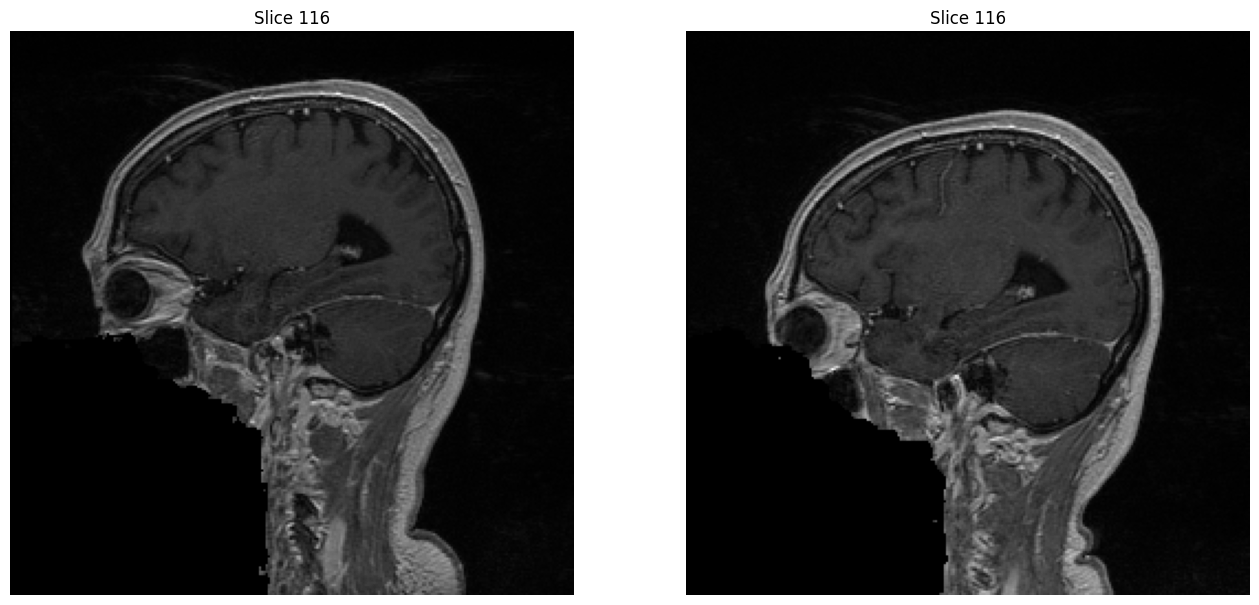

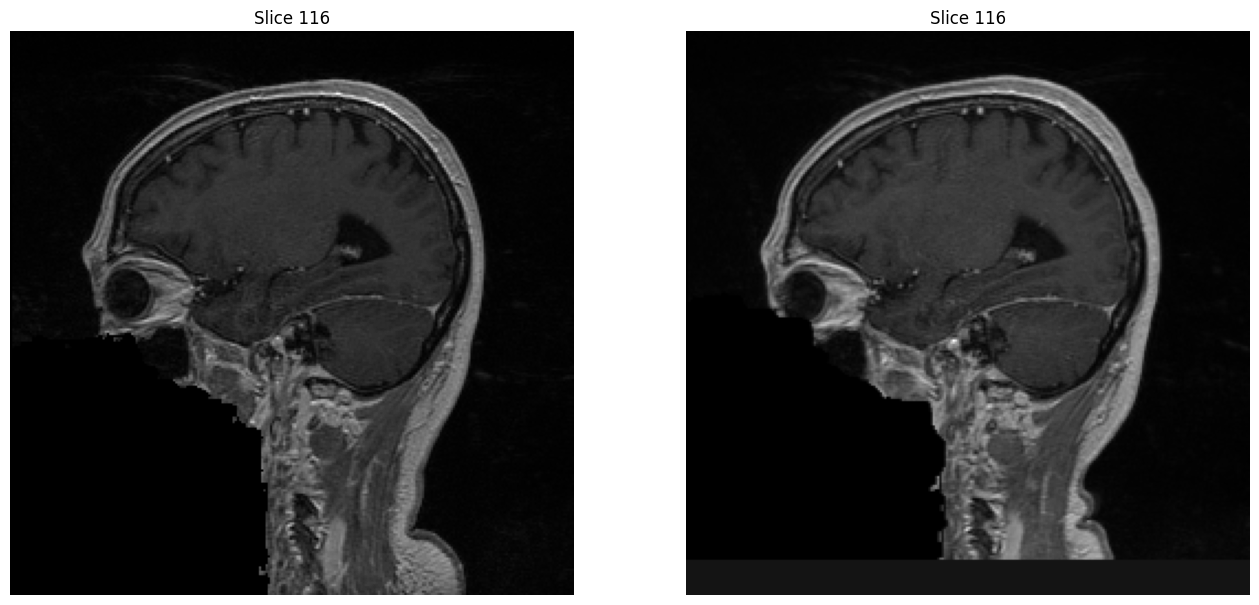

In [16]:
display_images(image1F, image2F, 116)
display_images(image1F, registered_image_rigid, 116)

Dans l'ensemble, le processus d'enregistrement a aligné l'image mobile sur l'image fixe, ce qui a donné l'image enregistrée avec la même taille que les images d'origine.

### 2. Recalage affine

La fonction `register_images_affine` effectue l'enregistrement de deux images tridimensionnelles, `fixed_image` et `moving_image`, en utilisant une transformation affine. Voici comment la fonction est implémentée: 

In [17]:
def register_images_affine(fixed_image, moving_image):
    
    TransformType = itk.AffineTransform[itk.D, Dimension]
    OptimizerType = itk.RegularStepGradientDescentOptimizer
    MetricType = itk.MeanSquaresImageToImageMetric[ImageTypeF, ImageTypeF]
    InterpolatorType = itk.LinearInterpolateImageFunction[ImageTypeF, itk.D]
    RegistrationType = itk.ImageRegistrationMethod[ImageTypeF, ImageTypeF]

    metric = MetricType.New()
    optimizer = OptimizerType.New()
    interpolator = InterpolatorType.New()
    registration = RegistrationType.New()
    transform = TransformType.New()

    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInterpolator(interpolator)
    registration.SetTransform(transform)

    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)
    registration.SetFixedImageRegion(fixed_image.GetBufferedRegion())

    registration.SetInitialTransformParameters(transform.GetParameters())

    translation_scale = 1.0 / 1000.0

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(transform.GetNumberOfParameters())

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0
    optimizer_scales[3] = 1.0
    optimizer_scales[4] = 1.0
    optimizer_scales[5] = 1.0
    optimizer_scales[6] = 1.0
    optimizer_scales[7] = 1.0
    optimizer_scales[8] = 1.0
    optimizer_scales[9] = translation_scale
    optimizer_scales[10] = translation_scale
    optimizer_scales[11] = translation_scale

    optimizer.SetScales(optimizer_scales)

    step_length = 1.0
    maxNumberOfIterations = 500

    optimizer.SetMaximumStepLength(step_length)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(maxNumberOfIterations)
    optimizer.MinimizeOn()

    try:
        registration.Update()
        print("Optimizer stop condition: " + str(registration.GetOptimizer().GetStopConditionDescription()))
    except Exception as err:
        print(err)
        return None
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    maxNumberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Iterations    = " + str(maxNumberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetParameters(finalParameters)
    finalTransform.SetFixedParameters(transform.GetFixedParameters())

    registered_image = resample_image(fixed_image, moving_image, finalTransform)

    return registered_image

In [18]:
registered_image_affine = register_images_affine(image1F, image2F)
print("Registered image size: " + str(registered_image_affine.GetLargestPossibleRegion().GetSize()))

Optimizer stop condition: RegularStepGradientDescentOptimizer: Step too small after 448 iterations. Current step (0.000976562) is less than minimum step (0.001).
Result = 
 Iterations    = 449
 Metric value  = 6671.612835684993
Registered image size: itkSize3 ([256, 256, 176])


À partir des résultats fournis par la fonction register_images_affine, on peut en déduire ce qui suit :

- La transformation affine a été capable de trouver une configuration qui minimise la différence quadratique moyenne entre l'image fixe et l'image mobile après la transformation. Cela suggère que la transformation affine est une bonne approximation pour aligner les deux images.

- Le nombre maximal d'itérations (500) n'a pas été atteint, ce qui indique que l'optimisation a convergé (449) avant cette limite.

- La valeur de la métrique obtenue à la convergence est de 6671.612835684993. Cette valeur représente la quantité de différence entre les intensités des voxels des images fixe et mobile après la transformation. Plus la valeur de la métrique est faible, plus l'alignement entre les images est considéré comme bon.

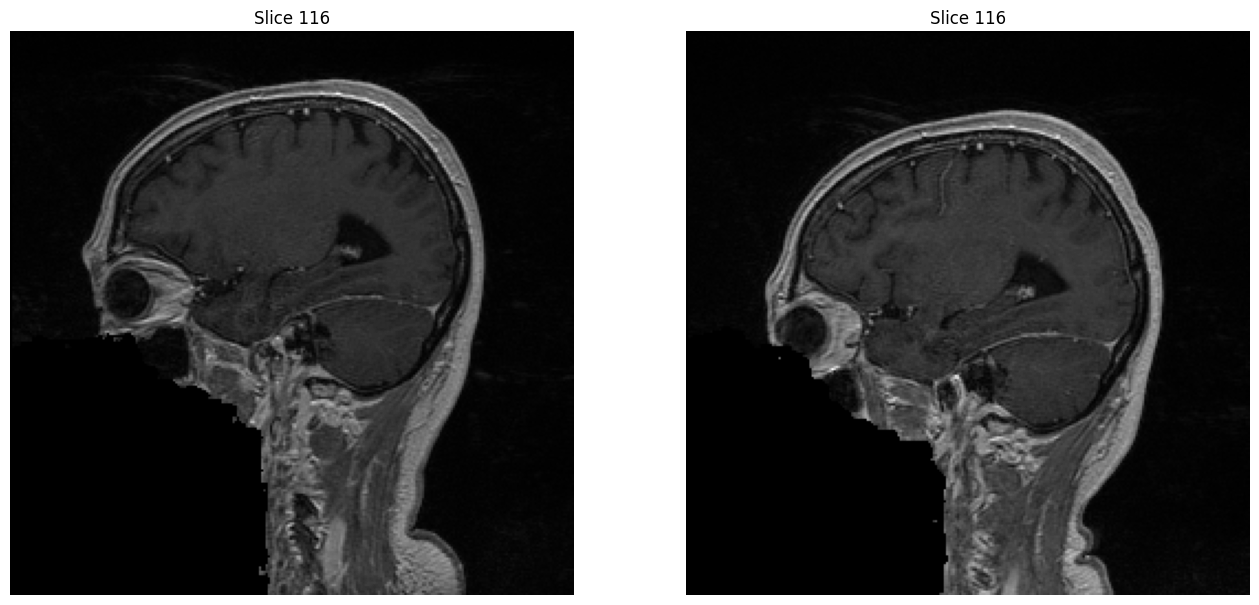

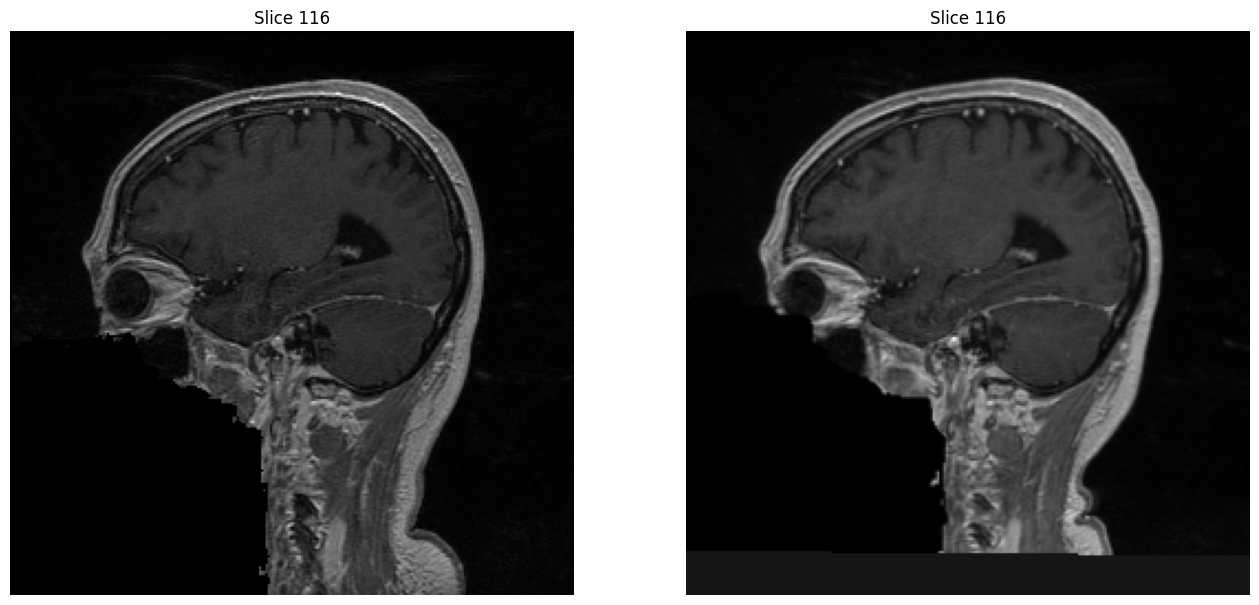

In [19]:
display_images(image1F, image2F, 116)
display_images(image1F, registered_image_affine, 116)

Dans l'ensemble, le processus d'enregistrement a aligné l'image mobile sur l'image fixe, ce qui a donné l'image enregistrée avec la même taille que les images d'origine.

## Benchmark

### Différence des deux images

#### Recalage rigide

Voici une fonction qui calcule la différence entre deux images et renvoie la somme des valeurs de différence.

In [20]:
def calculate_total_difference(image1, image2):
    Dimension = image1.GetImageDimension()
    
    resampler = itk.ResampleImageFilter.New(Input=image2)
    resampler.SetReferenceImage(image1)
    resampler.UseReferenceImageOn()
    resampler.Update()

    PixelType = itk.F
    subtract_filter = itk.SubtractImageFilter[itk.Image[PixelType, Dimension], itk.Image[PixelType, Dimension], itk.Image[PixelType, Dimension]].New()
    subtract_filter.SetInput1(image1)
    subtract_filter.SetInput2(resampler.GetOutput())

    abs_diff_filter = itk.AbsImageFilter[itk.Image[PixelType, Dimension], itk.Image[PixelType, Dimension]].New()
    abs_diff_filter.SetInput(subtract_filter.GetOutput())
    abs_diff_filter.Update()

    statistics_filter = itk.StatisticsImageFilter[itk.Image[PixelType, Dimension]].New()
    statistics_filter.SetInput(abs_diff_filter.GetOutput())
    statistics_filter.Update()

    return statistics_filter

In [21]:
total_diff1 = calculate_total_difference(image1F, image2F)
total_diff2 = calculate_total_difference(image1F, registered_image_rigid)
print("Total difference (fixed_image, moving_image):", total_diff1)
print("Total difference (fixed_image, registered_image_affine):", total_diff2)

Total difference (fixed_image, moving_image): StatisticsImageFilter (0x558740e87a50)
  RTTI typeinfo:   itk::StatisticsImageFilter<itk::Image<float, 3u> >
  Reference Count: 1
  Modified Time: 175534
  Debug: Off
  Object Name: 
  Observers: 
    none
  Inputs: 
    Primary: (0x558741cd6990) *
  Indexed Inputs: 
    0: Primary (0x558741cd6990)
  Required Input Names: Primary
  NumberOfRequiredInputs: 1
  Outputs: 
    Maximum: (0x5587409a6660)
    Mean: (0x55873e74cb60)
    Minimum: (0x5587417c6e50)
    Primary: (0)
    Sigma: (0x558741eb0840)
    Sum: (0x558740ab0ca0)
    SumOfSquares: (0x55874149a1c0)
    Variance: (0x5587406135c0)
  Indexed Outputs: 
    0: Primary (0)
  NumberOfRequiredOutputs: 0
  Number Of Work Units: 256
  ReleaseDataFlag: Off
  ReleaseDataBeforeUpdateFlag: On
  AbortGenerateData: Off
  Progress: 1
  Multithreader: 
    RTTI typeinfo:   itk::TBBMultiThreader
    Reference Count: 1
    Modified Time: 175493
    Debug: Off
    Object Name: 
    Observers: 
      n

En analysant les résultats, voici les conclusions sur la méthode rigid3d :

- La différence totale entre les images initiales (fixed_image, moving_image) est évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1734
    - Sum: 1.3808e+09
    - Mean: 119.712
    - Sigma: 185.442
    - Variance: 34388.7
    - SumOfSquares: 5.61949e+11
<br /> <br />
- La différence totale entre l'image fixe (fixed_image) et l'image enregistrée (registered_image_affine) est également évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1368.44
    - Sum: 5.89978e+08
    - Mean: 51.1497
    - Sigma: 103.222
    - Variance: 10654.8
    - SumOfSquares: 1.53074e+11

Ces résultats indiquent que la méthode rigid3d a réussi à réduire la différence entre l'image fixe et l'image enregistrée par rapport à la différence initiale entre les images initiales. Cependant, il y a toujours une certaine différence résiduelle entre les deux images.

#### Recalage affine

In [22]:
total_diff1 = calculate_total_difference(image1F, image2F)
total_diff2 = calculate_total_difference(image1F, registered_image_affine)
print("Total difference (fixed_image, moving_image):", total_diff1)
print("Total difference (fixed_image, registered_image_affine):", total_diff2)

Total difference (fixed_image, moving_image): StatisticsImageFilter (0x558740bb9080)
  RTTI typeinfo:   itk::StatisticsImageFilter<itk::Image<float, 3u> >
  Reference Count: 1
  Modified Time: 175851
  Debug: Off
  Object Name: 
  Observers: 
    none
  Inputs: 
    Primary: (0x558741cde720) *
  Indexed Inputs: 
    0: Primary (0x558741cde720)
  Required Input Names: Primary
  NumberOfRequiredInputs: 1
  Outputs: 
    Maximum: (0x5587410272b0)
    Mean: (0x5587410aa2d0)
    Minimum: (0x55874082efd0)
    Primary: (0)
    Sigma: (0x5587410aa380)
    Sum: (0x55874161de30)
    SumOfSquares: (0x55874108fdc0)
    Variance: (0x55874165ac90)
  Indexed Outputs: 
    0: Primary (0)
  NumberOfRequiredOutputs: 0
  Number Of Work Units: 256
  ReleaseDataFlag: Off
  ReleaseDataBeforeUpdateFlag: On
  AbortGenerateData: Off
  Progress: 1
  Multithreader: 
    RTTI typeinfo:   itk::TBBMultiThreader
    Reference Count: 1
    Modified Time: 175810
    Debug: Off
    Object Name: 
    Observers: 
      n

En analysant les résultats, voici les conclusions sur la méthode affine :

- La différence totale entre les images initiales (fixed_image, moving_image) est évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1734
    - Sum: 1.3808e+09
    - Mean: 119.712
    - Sigma: 185.442
    - Variance: 34388.7
    - SumOfSquares: 5.61949e+11
<br /> <br />
- La différence totale entre l'image fixe (fixed_image) et l'image enregistrée avec la transformation affine (registered_image_affine) est également évaluée à l'aide du filtre StatisticsImageFilter :
    - Count: 11534336
    - Minimum: 0
    - Maximum: 1358
    - Sum: 5.41158e+08
    - Mean: 46.9171
    - Sigma: 95.2594
    - Variance: 9074.34
    - SumOfSquares: 1.30056e+11

Ces résultats indiquent que la méthode affine a réduit la différence entre l'image fixe et l'image enregistrée par rapport à la méthode rigid3d. La différence totale entre les deux images est plus faible avec la méthode affine, ce qui suggère que cette méthode est meilleure que la méthode rigid3d en termes de mesure de la différence entre les images.

---

# Partie 2 : Segmentation
---

Nous voulons segmenter la tumeur dans les images.

## Pipeline

Nous avons normalisé les données au préalable, puis nous avons appliqué des filtres de segmentation sur les données normalisées et recalées.

In [23]:
def normalize_image(image):
    InputPixelType = itk.ctype('float')
    OutputPixelType = itk.ctype('float')
    InputImageType = itk.Image[InputPixelType, Dimension]
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    RescaleFilterType = itk.RescaleIntensityImageFilter[InputImageType, OutputImageType]
    rescaleFilter = RescaleFilterType.New()

    rescaleFilter.SetInput(image)
    rescaleFilter.SetOutputMinimum(0)
    rescaleFilter.SetOutputMaximum(255)

    try:
        rescaleFilter.Update()
    except Exception as e:
        print(e)
        return None
    
    return rescaleFilter.GetOutput()

Nous avons choisi de prendre l'image recalée avec la méthode rigide.

In [24]:
image_normalized = normalize_image(registered_image_rigid)

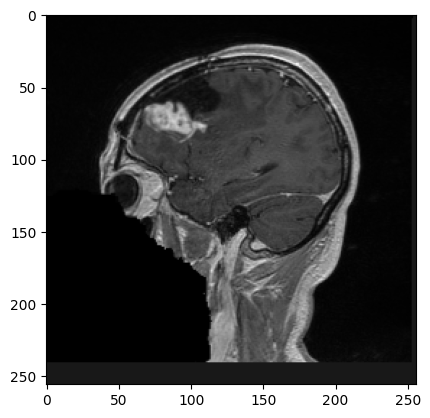

In [25]:
display_image(image_normalized, 55)

### 1. Segmentation Watershed

Tout d'abord, nous avons utilisé un filtre de segmentation de type Watershed pour segmenter l'image.

In [26]:
def segmentation_watershed(image):

    InternalPixelType = itk.F
    InternalImageType = itk.Image[InternalPixelType, Dimension]

    GradientMagnitudeImageFilterType = itk.GradientMagnitudeRecursiveGaussianImageFilter[InternalImageType, InternalImageType]
    gradientMagnitudeImageFilter = GradientMagnitudeImageFilterType.New()
    gradientMagnitudeImageFilter.SetInput(image)
    gradientMagnitudeImageFilter.SetSigma(1.0)

    WatershedFilterType = itk.WatershedImageFilter[InternalImageType]
    watershedFilter = WatershedFilterType.New()

    watershedFilter.SetInput(gradientMagnitudeImageFilter.GetOutput())
    watershedFilter.SetThreshold(0.01)
    watershedFilter.SetLevel(0.2)
    
    watershedFilter.Update()

    return watershedFilter.GetOutput()

In [27]:
watershed = segmentation_watershed(image_normalized)
print("watershed size: " + str(watershed.GetLargestPossibleRegion().GetSize()))

watershed size: itkSize3 ([256, 256, 176])


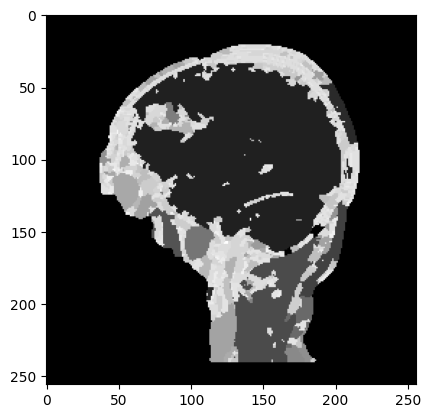

In [28]:
display_image(watershed, 55)

Le résultat de la segmentation Watershed arrive à segmenter la tumeur, mais il segmente beaucoup d'autres parties de l'image. Nous avons donc décidé d'utiliser un autre filtre de segmentation.

### 2. Segmentation Otsu Threshold

Ensuite nous avons utilisé un filtre de segmentation de type Otsu Threshold pour segmenter l'image.

In [29]:
def segmentation_otsu(image):
    InputPixelType = itk.ctype('unsigned char')
    OutputPixelType = itk.ctype('unsigned char')
    InputImageType = itk.Image[InputPixelType, Dimension]
    OutputImageType = itk.Image[OutputPixelType, Dimension]

    FilterType = itk.OtsuThresholdImageFilter[InputImageType, OutputImageType]
    otsuFilter = FilterType.New()

    otsuFilter.SetInput(image)
    otsuFilter.SetInsideValue(0)
    otsuFilter.SetOutsideValue(255)

    try:
        otsuFilter.Update()
    except Exception as e:
        print(e)
        return None
    
    return otsuFilter.GetOutput()

In [30]:
otsu = segmentation_otsu(image1UC)
print("otsu size: " + str(otsu.GetLargestPossibleRegion().GetSize()))

otsu size: itkSize3 ([256, 256, 176])


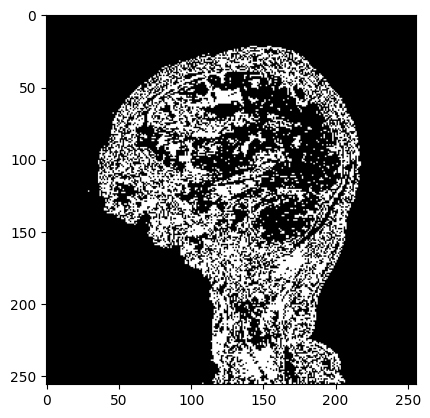

In [31]:
display_image(otsu, 55)

Avec ce filtre, nous n'avons pas pu segmenter la tumeur.

### 3. Segmentation Isolated Connected

Puis nous avons utilisé un filtre de segmentation de type Isolated Connected pour segmenter l'image.

In [32]:
def segmentation_isolated_connected(image):
    
    InternalPixelType = itk.F
    InternalImageType = itk.Image[InternalPixelType, Dimension]

    CurvatureFlowImageFilterType = itk.CurvatureFlowImageFilter[InternalImageType, InternalImageType]
    smoothing = CurvatureFlowImageFilterType.New()

    IsolatedConnectedFilterType = itk.IsolatedConnectedImageFilter[InternalImageType, InternalImageType]
    isolatedConnected = IsolatedConnectedFilterType.New()

    smoothing.SetInput(image)
    isolatedConnected.SetInput(smoothing.GetOutput())

    isolatedConnected.SetLower(0)
    isolatedConnected.AddSeed1([50, 50, 50])
    isolatedConnected.AddSeed2([100, 100, 100])
    isolatedConnected.SetReplaceValue(255)

    try:
        isolatedConnected.Update()
    except Exception as e:
        print(e)
        return None
    
    return isolatedConnected.GetOutput()

In [33]:
iso_con = segmentation_isolated_connected(image_normalized)
print("iso_con size: " + str(iso_con.GetLargestPossibleRegion().GetSize()))

iso_con size: itkSize3 ([256, 256, 176])


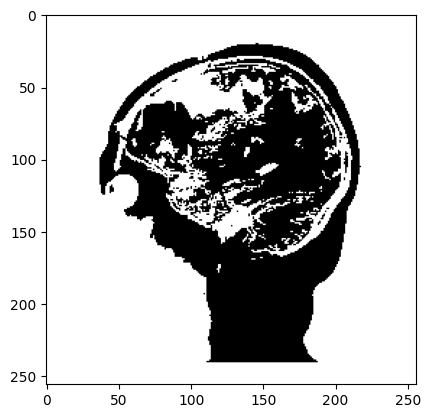

In [34]:
display_image(iso_con, 55)

Avec ce filtre, nous n'avons pas pu segmenter la tumeur.

### 4. Segmentation Neighbourhood Connected

Enfin nous avons utilisé un filtre de segmentation de type Neighbourhood Connected pour segmenter l'image.

In [35]:
def segmentation_neighborhood_connected(image, seed, lower, upper):

    InternalPixelType = itk.F
    InternalImageType = itk.Image[InternalPixelType, Dimension]

    CurvatureFlowImageFilterType = itk.CurvatureFlowImageFilter[InternalImageType, InternalImageType]
    smoothing = CurvatureFlowImageFilterType.New()

    NeighborhoodConnectedFilterType = itk.NeighborhoodConnectedImageFilter[InternalImageType, InternalImageType]
    neighborhoodConnected = NeighborhoodConnectedFilterType.New()

    smoothing.SetInput(image)
    neighborhoodConnected.SetInput(smoothing.GetOutput())
    
    smoothing.SetNumberOfIterations(5)
    smoothing.SetTimeStep(0.125)

    neighborhoodConnected.SetLower(lower)
    neighborhoodConnected.SetUpper(upper)

    radius = 1
    neighborhoodConnected.SetRadius(radius)

    neighborhoodConnected.SetSeed(seed)
    neighborhoodConnected.SetReplaceValue(255)

    try:
        neighborhoodConnected.Update()
    except Exception as e:
        print(e)
        return None
    
    return neighborhoodConnected.GetOutput()

Après avoir essayé plusieurs paramètres, nous avons réussi à segmenter la tumeur, en utilisant trouvant une des nombreuses seeds qui permettent de segmenter la tumeur.

Nous avons donc appliquer ce filtre sur l'image recalée avec la méthode affine, et l'image du lot 1.

#### Image du lot 1

In [36]:
image_normalized_1F = itk.array_from_image(image1F)
image_normalized_1F = (image_normalized_1F - image_normalized_1F.min()) / (image_normalized_1F.max() - image_normalized_1F.min()) * 255
image_normalized_1F = itk.image_from_array(image_normalized_1F)

nei_con_1F = segmentation_neighborhood_connected(image_normalized_1F, [88, 70, 57], 50, 140)
print("nei_con size: " + str(nei_con_1F.GetLargestPossibleRegion().GetSize()))

nei_con size: itkSize3 ([256, 256, 176])


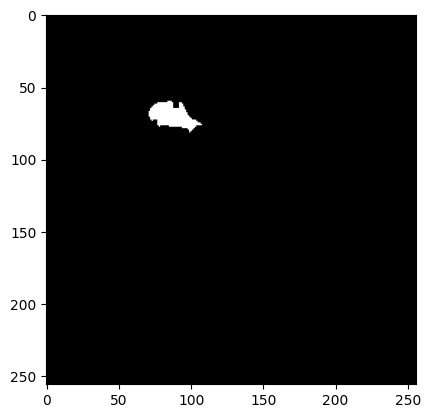

In [37]:
display_image(nei_con_1F, 55)

#### Image recalée avec la méthode rigide

In [38]:
image_normalized_rigid = itk.array_from_image(registered_image_rigid)
image_normalized_rigid = (image_normalized_rigid - image_normalized_rigid.min()) / (image_normalized_rigid.max() - image_normalized_rigid.min()) * 255
image_normalized_rigid = itk.image_from_array(image_normalized_rigid)

nei_con_rigid = segmentation_neighborhood_connected(image_normalized_rigid, [88, 70, 57], 50, 155)
print("nei_con size: " + str(nei_con_rigid.GetLargestPossibleRegion().GetSize()))

nei_con size: itkSize3 ([256, 256, 176])


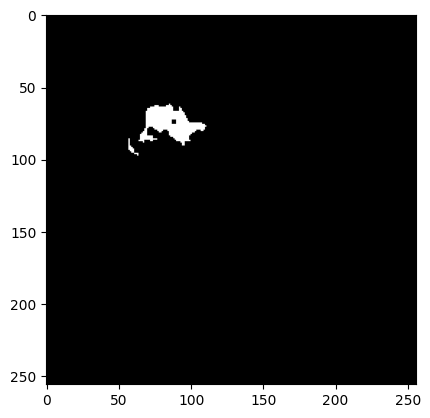

In [39]:
display_image(nei_con_rigid, 55)

Nous avons pu segmenter la tumeur avec ce filtre.

---

Nous allons analyser les résultats de la segmentation en utilisant des mesures de similarité et de différence.

In [40]:
def calculate_dice_similarity(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    intersection = np.logical_and(arr1, arr2)
    dice_coefficient = 2.0 * intersection.sum() / (arr1.sum() + arr2.sum())

    return dice_coefficient

In [41]:
dice_similarity = calculate_dice_similarity(nei_con_1F, nei_con_rigid)
print("Dice similarity: " + str(dice_similarity))

Dice similarity: 0.002424449773446995


In [42]:
def calculate_volume_difference(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    voxel_volume = image1.GetSpacing()[0] * image1.GetSpacing()[1] * image1.GetSpacing()[2]

    volume1 = arr1.sum() * voxel_volume
    volume2 = arr2.sum() * voxel_volume
    diff_volume = volume2 - volume1

    return volume1, volume2, diff_volume

In [43]:
volume1, volume2, diff_volume = calculate_volume_difference(nei_con_1F, nei_con_rigid)
print("Volume 1: " + str(volume1))
print("Volume 2: " + str(volume2))
print("Volume difference: " + str(diff_volume))

Volume 1: 1765875.0
Volume 2: 2969220.0
Volume difference: 1203345.0


In [44]:
def calculate_intensity_difference(image1, image2):
    arr1 = itk.array_from_image(image1)
    arr2 = itk.array_from_image(image2)

    diff_intensity = np.abs(arr2 - arr1).mean()

    return diff_intensity

In [45]:
diff_intensity = calculate_intensity_difference(nei_con_1F, nei_con_rigid)
print("Intensity difference: " + str(diff_intensity))

Intensity difference: 0.15672293


In [51]:
def visualize_image_difference(image1, image2, slice_number):
    arr1 = itk.array_view_from_image(image1)
    arr2 = itk.array_view_from_image(image2)

    diff = np.abs(arr2 + arr1)

    plt.figure(figsize=(8, 8))
    plt.imshow(diff[slice_number, :, :], cmap='gray')
    plt.axis('off')
    plt.title('Difference between Image 1 and Image 2')
    plt.show()

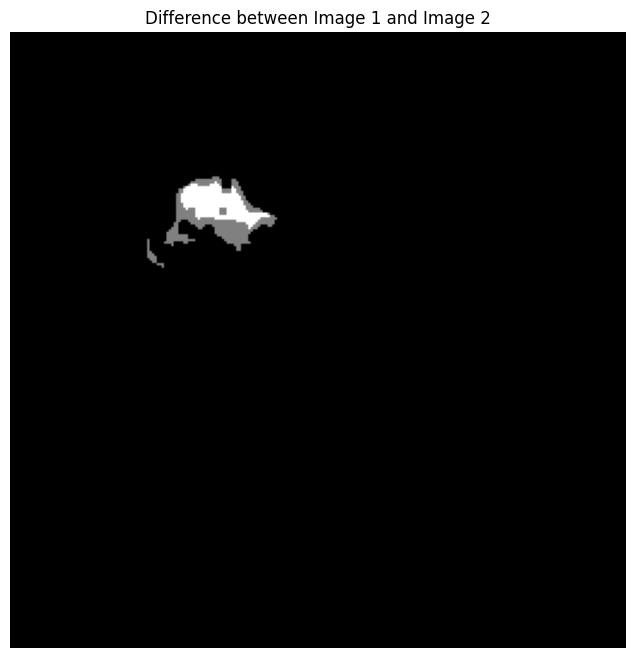

In [52]:
visualize_image_difference(nei_con_1F, nei_con_rigid, 55)

- Selon les calculs effectués, voici la conclusion concernant les deux tumeurs :

    - Similarité de Dice : Le coefficient de similarité de Dice de 0,0024 indique un chevauchement ou une similarité très faible entre les deux régions tumorales. Cela signifie que l'intersection des régions tumorales dans les deux images est extrêmement petite par rapport à leur union.

    - Différence de volume : La différence de volume entre les deux régions tumorales est de 1 203 345,0 unités cubes. Cette valeur représente la disparité de taille entre les deux tumeurs. La deuxième tumeur (volume 2 : 2 969 220,0 unités cubes) est significativement plus grande que la première tumeur (volume 1 : 1 765 875,0 unités cubes).

    - Différence d'intensité : La différence d'intensité des valeurs de voxels entre les deux régions tumorales est de 0,1567. Cette valeur indique la dissimilarité des intensités de pixels entre les deux tumeurs. Une différence d'intensité plus élevée suggère que les deux tumeurs présentent des caractéristiques d'intensité de pixels distinctes.

- En conclusion, les deux tumeurs ont très peu de chevauchement, avec une différence significative à la fois en termes de volume et d'intensité, la deuxième est plus volumineuse que la première. Elles semblent être des régions tumorales distinctes avec des similarités minimales en ce qui concerne la forme, la taille et les caractéristiques d'intensité. Cela est peut-être dû au choix de la méthode de recalage rigide, qui n'a pas réussi à aligner les deux images de manière optimale. Une méthode de recalage plus avancée, comme la méthode affine, pourrait donner de meilleurs résultats.